#### Import Required LIbraries 

In [59]:
import rasterio
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from rasterio.features import rasterize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [60]:
#specify color for classification
colors = [
    "black",        # Class 0
    "darkgreen",    # Class 1
    "lightgreen",   # Class 2
    "#B8860B",      # Class 3 (Dark Yellow - DarkGoldenRod)
    "#800020",      # Class 4 (Burgundy)
    "#FF8C00",      # Class 5 (Dark Orange)
    "darkblue",     # Class 6
    "lightskyblue", # Class 7 (Light Blue)
    "#0ABAB5",      # Class 8 (Tiffany - a teal/cyan shade)
    "#556B2F",      # Class 9 (Other tone of green - DarkOliveGreen)
    "#FFD700",      # Class 10 (Other tone of yellow - Gold)
    "#FFB6C1",      # Class 11 (Light Red)
    "red",          # Class 12
    "#FFA07A",      # Class 13 (Light Orange - LightSalmon)
    "#FFFFE0"       # Class 14 (Light Yellow - LightYellow)
]

# Create a custom colormap
cmap = ListedColormap(colors)

#### Load the image and shape file data

In [61]:
# Paths to the data
raster_path = "data/AVIRIS_C_SWIR.tif"
shapefile_path = "data/training_data_SWIR.shp"

# Step 1: Load Raster Data
with rasterio.open(raster_path) as src:
    raster_data = src.read()  # Read all bands
    raster_meta = src.meta
    transform = src.transform

print(raster_data.shape)


# Step 2: Load Shapefile
shapefile = gpd.read_file(shapefile_path)

print("Shapefile head:")
print(shapefile.head())

(86, 1163, 665)
Shapefile head:
    Shape_Leng    Shape_Area  classvalue classname  \
0   789.755128  44965.592253           1    class1   
1  1191.011552  95261.166155           1    class1   
2   839.174581  50118.375489           1    class1   
3   759.545936  36950.686188           1    class1   
4   616.456425  26192.592464           1    class1   

                                            geometry  
0  POLYGON ((487236.240 4152906.459, 487328.264 4...  
1  POLYGON ((485537.543 4149487.978, 485615.988 4...  
2  POLYGON ((487131.667 4150841.497, 487137.244 4...  
3  POLYGON ((483258.730 4154849.507, 483296.944 4...  
4  POLYGON ((483265.266 4156530.252, 483328.009 4...  


In [62]:
# Analyze raster data

print(f"Raster data type: {raster_data.dtype}")
# Print min and max values of the original raster data
print(f"Min value before normalization: {raster_data.min()}")
print(f"Max value before normalization: {raster_data.max()}")

Raster data type: float32
Min value before normalization: -1706.0
Max value before normalization: 9213.5


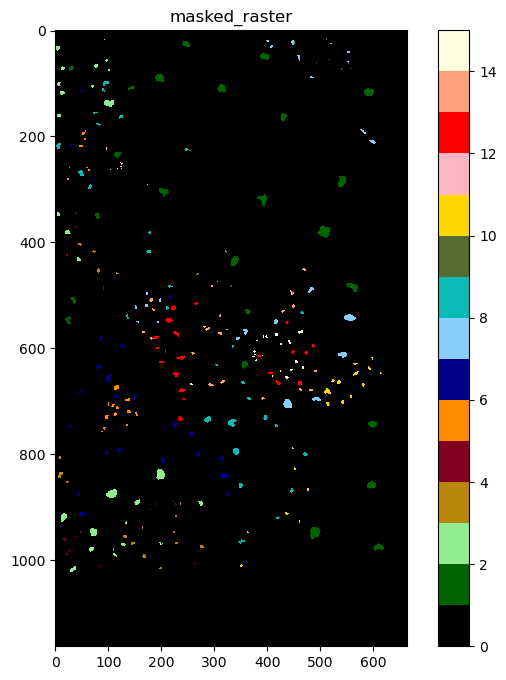

Number of labeled pixels: 13734


In [64]:
# Step 3: Rasterize Shapefile
# This code converts vector data (shapefile geometries) into a raster grid where each pixel is assigned a class value based on the polygon 
# it falls into. The output, rasterized_labels, is a 2D array of shape (height, width), with each pixel containing a class label.
shapes = ((geom, value) for geom, value in zip(shapefile.geometry, shapefile['classvalue']))
rasterized_labels = rasterize(shapes, out_shape=raster_data.shape[1:], transform=transform)

# Define the class to display (e.g., class 5)
#class_to_display = 5

# Mask all other classes, keeping only class 5
#masked_raster = np.where(rasterized_labels == class_to_display, class_to_display, np.nan)

# Display the masked raster
# Display rasterized labels
plt.figure(figsize=(8, 8))
plt.imshow(rasterized_labels, cmap=cmap, interpolation="none")
plt.title("masked_raster")
plt.colorbar()
plt.show()

labeled_pixels = np.sum(rasterized_labels > 0)

# Print the number of labeled pixels
print(f"Number of labeled pixels: {labeled_pixels}")

#### Preparation of Training Data

In [5]:
# Step 4: Prepare Training Data

# Clip negative values to zero
raster_data_clipped = np.clip(raster_data, 0, None)

# Normalize the clipped raster data
raster_data_normalized = (raster_data_clipped - raster_data_clipped.min()) / (raster_data_clipped.max() - raster_data_clipped.min())

# Check min and max after clipping and normalization
print(f"Min value after clipping and normalization: {raster_data_normalized.min()}")
print(f"Max value after clipping and normalization: {raster_data_normalized.max()}")

Min value after clipping and normalization: 0.0
Max value after clipping and normalization: 1.0


In [6]:
# Flatten the raster and labels for pixel-based classification
X = raster_data_normalized.reshape(raster_data.shape[0], -1).T  # Shape: (num_pixels, num_channels)
y = rasterized_labels.flatten()  # Shape: (num_pixels,)

# Filter out unlabeled pixels (e.g., background where y == 0)
mask = y > 0
X = X[mask]
y = y[mask]

# Adjust labels to start from 0
y = y - 1

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Reshape X_train and X_test to match 1D CNN input
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

X_train shape: (10987, 86)
y_train shape: (10987,)
X_test shape: (2747, 86)
y_test shape: (2747,)


In [10]:
# Analyze input data for cnn
import openpyxl

df = pd.DataFrame(X)  # X contains the normalized pixel values for each feature (spectral band)
df['label'] = y  # Add the labels as a new column

# Save the DataFrame to Excel
#df.to_csv("input_data_for_training.csv", index=False)

[[0.27872145 0.27703914 0.27568242 ... 0.22434472 0.21338254 0.17458078]
 [0.26765072 0.26434037 0.27416295 ... 0.15976556 0.23774895 0.19308624]
 [0.37890053 0.37152004 0.37119445 ... 0.3334238  0.32886526 0.2747056 ]
 ...
 [0.32555488 0.32083356 0.3228415  ... 0.22152276 0.17241006 0.17680578]
 [0.30341345 0.3051501  0.30379337 ... 0.2143051  0.2168557  0.20274597]
 [0.3369512  0.32609758 0.32891953 ... 0.21028925 0.16112226 0.16426983]]


#### Define the 1D CNN model

In [11]:
def create_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        Conv1D(128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.4),
        Conv1D(256, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.4),
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model


In [15]:
# Initialize and compile the model
input_shape = (X_train_cnn.shape[1], 1) #each pixel is represented as a 1D vector of 86
num_classes = len(np.unique(y_train)) #number of unique class in training dataset
model = create_model(input_shape, num_classes) #init model 
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
model_checkpoint = ModelCheckpoint("model/best_model.h5", monitor='val_loss', save_best_only=True, mode='min', verbose=1)

#### Model training

In [34]:
# Train the model
history = model.fit(
    X_train_cnn, y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_test_cnn, y_test),
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

Epoch 1/50
86/86 [==============================] - ETA: 0s - loss: 0.1501 - accuracy: 0.9470
Epoch 1: val_loss improved from 5.58998 to 1.23708, saving model to model\best_model.h5
86/86 [==============================] - 5s 60ms/step - loss: 0.1501 - accuracy: 0.9470 - val_loss: 1.2371 - val_accuracy: 0.5992 - lr: 0.0010
Epoch 2/50
85/86 [============================>.] - ETA: 0s - loss: 0.1411 - accuracy: 0.9502
Epoch 2: val_loss improved from 1.23708 to 0.17559, saving model to model\best_model.h5
86/86 [==============================] - 5s 54ms/step - loss: 0.1410 - accuracy: 0.9504 - val_loss: 0.1756 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 3/50
86/86 [==============================] - ETA: 0s - loss: 0.1337 - accuracy: 0.9514
Epoch 3: val_loss did not improve from 0.17559
86/86 [==============================] - 5s 57ms/step - loss: 0.1337 - accuracy: 0.9514 - val_loss: 1.3430 - val_accuracy: 0.5420 - lr: 0.0010
Epoch 4/50
86/86 [==============================] - ETA: 0s - loss

#### Model testing Accuracy

In [35]:
# Load the best model after training
best_model = load_model("model/best_model.h5")

# Evaluate the best model
loss, accuracy = best_model.evaluate(X_test_cnn, y_test)
print(f"Best Model Test Loss: {loss}")
print(f"Best Model Test Accuracy: {accuracy}")

86/86 [==============================] - 1s 10ms/step - loss: 0.0244 - accuracy: 0.9887
Best Model Test Loss: 0.024442380294203758
Best Model Test Accuracy: 0.9887149333953857


#### Plot Accuracy and Loss

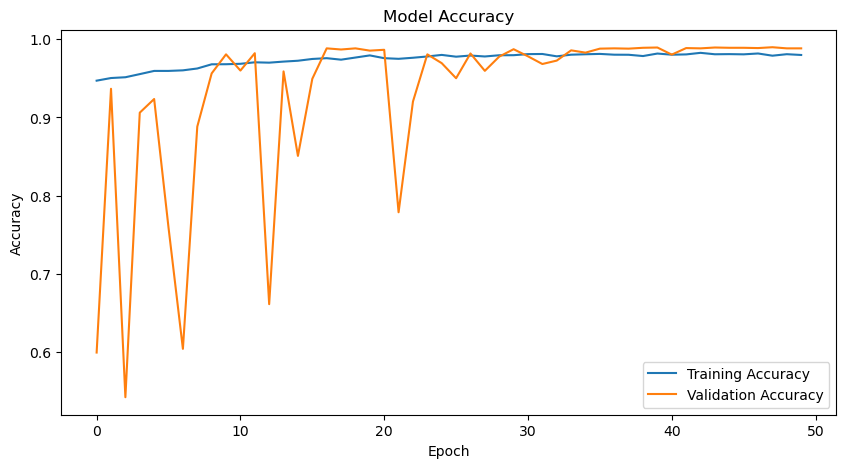

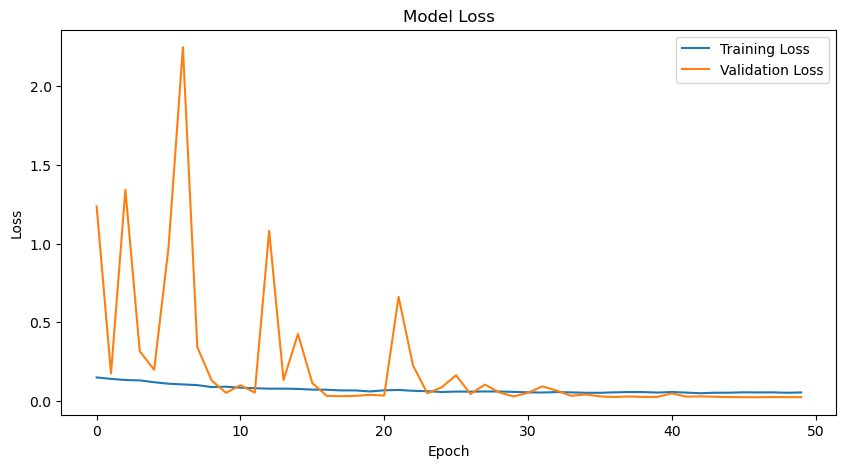

In [36]:
# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Plot Confusion Matrix

#### Predicted Class Map

In [38]:
# Ensure `X_cnn` includes all labeled pixels
X_cnn = X.reshape(mask.sum(), X.shape[1], 1)  # Shape: (13734, 86, 1)

# Predict on all labeled pixels
y_pred = best_model.predict(X_cnn)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Verify the new shape
print("y_pred_classes shape:", y_pred_classes.shape)
print("Expected mask.sum():", mask.sum())

# Flatten the raster labels
rasterized_labels_flat = rasterized_labels.flatten()

# Initialize an empty array for predictions
predicted_raster_flat = np.zeros_like(rasterized_labels_flat)

# Assign predictions only to valid pixels (mask == True)
predicted_raster_flat[mask] = y_pred_classes

# Reshape back to original raster shape
predicted_raster = predicted_raster_flat.reshape(rasterized_labels.shape)

430/430 [==============================] - 4s 9ms/step
y_pred_classes shape: (13734,)
Expected mask.sum(): 13734


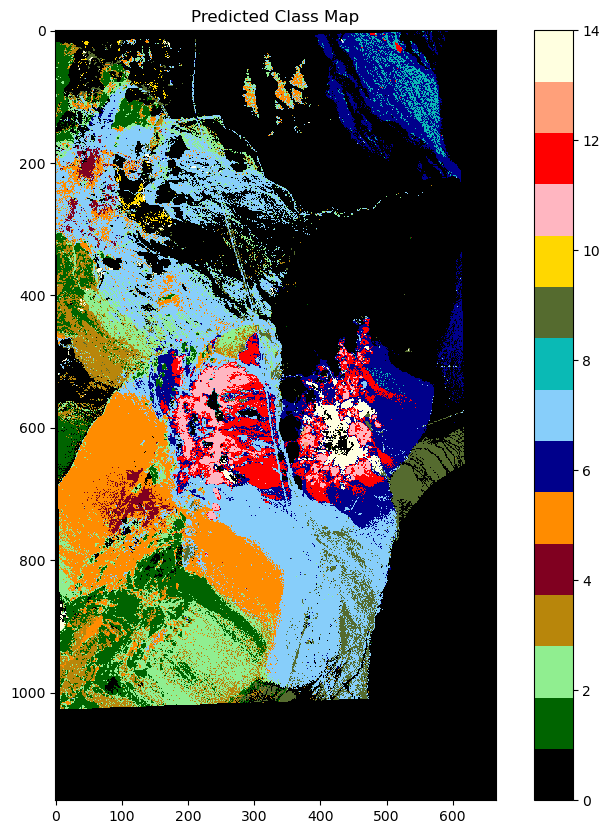

In [66]:
#Visualize Predicted Class Map
plt.figure(figsize=(10, 10))
plt.imshow(predicted_raster, cmap=cmap, interpolation="none")
plt.title("Predicted Class Map")
plt.colorbar()
plt.show()


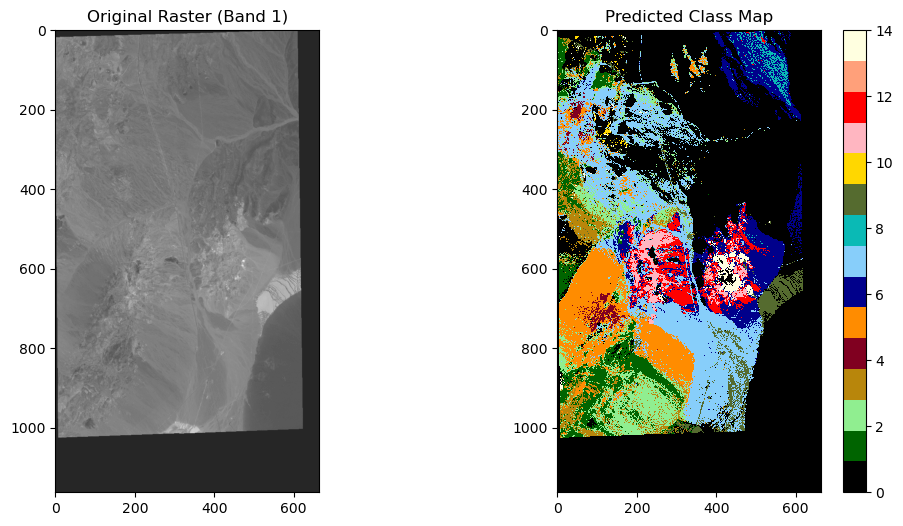

In [67]:
plt.figure(figsize=(12, 6))

# Original Raster
plt.subplot(1, 2, 1)
plt.imshow(raster_data[0], cmap="gray")
plt.title("Original Raster (Band 1)")

plt.subplot(1, 2, 2)
plt.imshow(predicted_raster, cmap=cmap, interpolation="none")
plt.title("Predicted Class Map")
plt.colorbar()

plt.show()


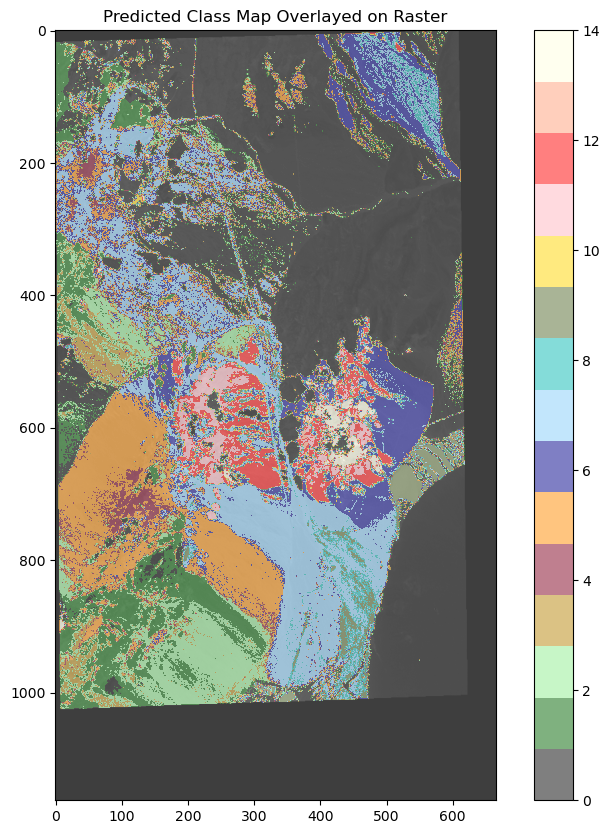

In [70]:
#Visualize Predicted Class Map on Raster
plt.figure(figsize=(10, 10))
plt.imshow(raster_data[0], cmap="gray", alpha=0.6)  # Base raster
plt.imshow(predicted_raster, cmap=cmap, alpha=0.5)  # Overlay predictions
plt.title("Predicted Class Map Overlayed on Raster")
plt.colorbar()
plt.show()

86/86 [==============================] - 1s 10ms/step


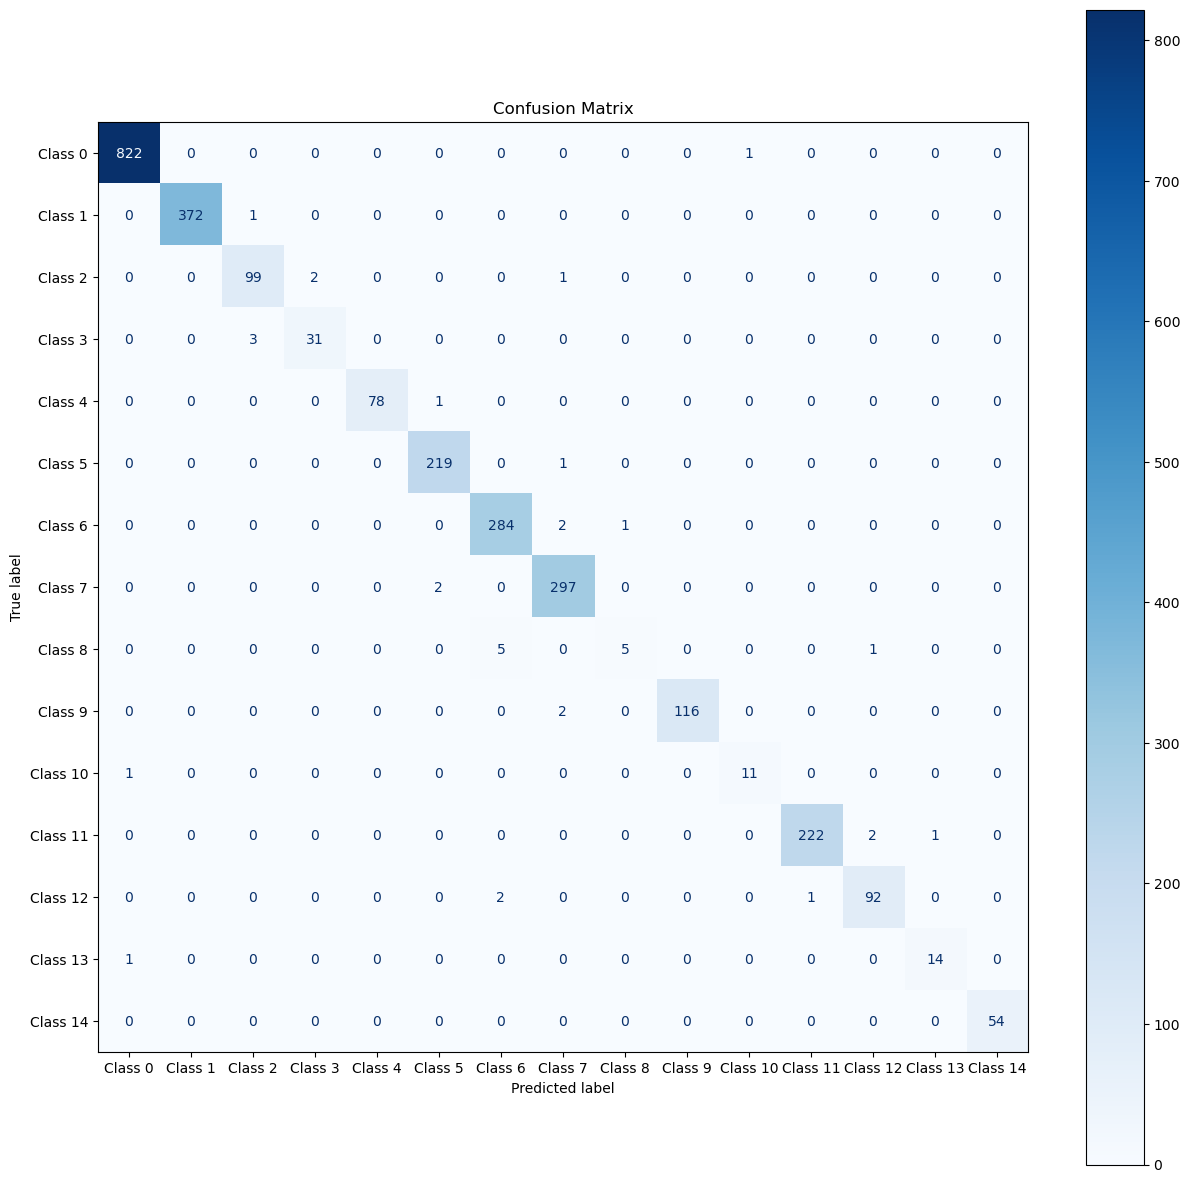

In [37]:
# Generate predictions
y_pred = best_model.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
class_names = [f"Class {i}" for i in range(len(np.unique(y_test)))]

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(15, 15))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix")
plt.show()

### Prediction/Deployment with the raw raster data

In [54]:
# Paths to the data
raster_path = "data/AVIRIS_C_SWIR.tif"

# Load Raster Data
with rasterio.open(raster_path) as src:
    raster_data = src.read()  # Read all bands
    raster_meta = src.meta
    transform = src.transform

# Clip negative values to zero
raster_data_clipped = np.clip(raster_data, 0, None)

# Normalize the clipped data
raster_data_normalized = (raster_data_clipped - raster_data_clipped.min()) / (raster_data_clipped.max() - raster_data_clipped.min())

# Check min and max after clipping and normalization
print(f"Min value after clipping and normalization: {raster_data_normalized.min()}")
print(f"Max value after clipping and normalization: {raster_data_normalized.max()}")

Min value after clipping and normalization: 0.0
Max value after clipping and normalization: 1.0


In [55]:
# Step 1: Flatten the spatial dimensions (height x width) into a single dimension
num_pixels = raster_data_normalized.shape[1] * raster_data_normalized.shape[2]
num_bands = raster_data_normalized.shape[0]

# Reshape the data into (num_pixels, num_bands)
X_reshaped = raster_data_normalized.reshape(num_bands, -1).T  # Shape: (num_pixels, num_bands)

# Step 2: Reshape the data into (num_pixels, num_bands, 1) for the 1D CNN
X_reshaped_cnn = X_reshaped.reshape(X_reshaped.shape[0], X_reshaped.shape[1], 1)

# Check the reshaped data shape
print(f"Reshaped raster data for 1D CNN: {X_reshaped_cnn.shape}")

Reshaped raster data for 1D CNN: (773395, 86, 1)


In [56]:
# Step 3: Load the Best Model and Predict
best_model = load_model("model/best_model.h5")

# Step 4: Predict with the reshaped data
deployment = best_model.predict(X_reshaped_cnn)

# Step 5: Reshape Predictions to Original Raster Format
# Since 'deployment' will contain predicted class probabilities, you need to take the argmax to get the final class
predicted_raster = deployment.argmax(axis=1).reshape(raster_data.shape[1], raster_data.shape[2])


24169/24169 [==============================] - 228s 9ms/step


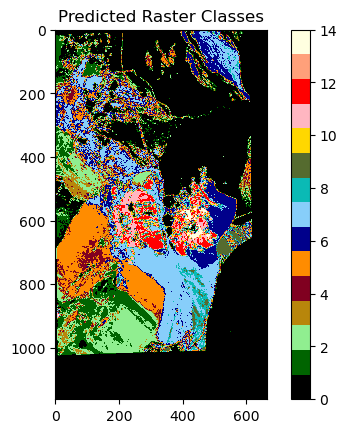

In [57]:
# Display the predicted raw raster image (optional)
plt.imshow(predicted_raster, cmap=cmap) 
plt.title("Predicted Raw Raster Classes")
plt.colorbar()
plt.show()
